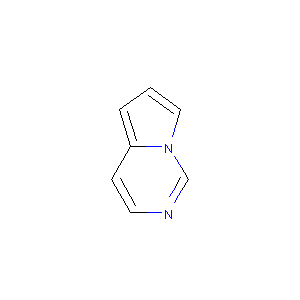

In [6]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import MolToImage

MolToImage(Chem.MolFromSmiles('c1nccc2n1ccc2'))


In [ ]:
fname = '../data/250k_rndm_zinc_drugs_clean.smi'

with open(fname) as f:
    smiles = f.readlines()

for i in range(len(smiles)):
    smiles[i] = smiles[i].strip()


In [12]:
import sys
sys.path.append('..')
from generative_playground.models import grammar_ed_models as grammar_model

# We load the auto-encoder
grammar_weights = '../pretrained/my_molecules.mdl'
grammar_model = grammar_model.ZincGrammarModel(grammar_weights)
z = grammar_model.encode(['c1nccc2n1ccc2'])
new_smile = grammar_model.decode(z)

Trying to load model parameters from  ../pretrained/my_molecules.mdl
Success!


TypeError: 'int' object is not callable